# Model - Image Captioning

Here I will run a model to generate captions for objects. This will be done in a few step.  
(the main structure of steps and dataset from https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/)

1. Extract feature from pretrained network for object recognition.  
2. Using the flicker dataset with labels, train CNN/RNN model 
3. Art Captioning: for this I'll try couple different method
    - test artworks on a model trained for object captioning
    - include art with description to the CNN/RNN 
    - include artworks to the CNN
    - include less concrete object images (e.g. cloud) to the CNN
    - train more abstract labeling in RNN
    
Additionally, some evaluation steps to take a look.
1. Check what type of objects are classified better or worse
2. Try semantic projection (abstract - concrete) to score the level of abstraction of each word and run statistical testing on how the model performance differs per the level of abstraction

In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from tensorflow.keras.applications import NASNetLarge 
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras.models import Model, model_from_json

import pickle

import os

import numpy as np
from timeit import default_timer as timer

In [3]:
flicker_img_dir = 'IMAGES/Flicker/Flicker8k_Dataset'
flicker_text_dir = 'IMAGES/Flicker/labels'

In [4]:
import gc

# remove unnecessary variables
def clean_up(vars_):
    for var in vars_:
        del var 
    print(gc.collect())

## Feature Extraction
---
First, extracting features from Flicker dataset using NASNet network.

In [5]:
def feature_extractor(dir_, network):
    ''' 
    iterate through files in dir_ 
    and get features running on network
    return a dictionary with image id as a key
    '''
    model = network()
    model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
    fnames = [x for x in os.listdir(dir_) if x.endswith('.jpg')]
    result = {}
    i = 1
    n = len(fnames)
    
    for fn in fnames:
        img = load_img(f'{dir_}/{fn}', target_size = (331, 331))
        img = np.expand_dims(img, 0)
        img = preprocess_input(img)
        feature = model.predict(img)
        ind = fn.split('.')[0]
        result[ind] = feature
        print(f'{i}/{n} feature extraction completed')
        i += 1
    return result

In [ ]:
features = feature_extractor(flicker_img_dir, NASNetLarge)

In [6]:
# saving the extracted features
with open('PKL/features.pkl', 'wb') as fp:
    pickle.dump(features, fp, pickle.HIGHEST_PROTOCOL)

In [6]:
# loading
with open('PKL/features.pkl', 'rb') as fp:
    features = pickle.load(fp)

## Preprocessing Description
---
Now I will clean up the descriptions. 

In [8]:
# read the description file
with open(f'{flicker_text_dir}/Flickr8k.token.txt', 'r') as fn:
    text = fn.readlines()

I'll create a dictionary with the image id as a key and the descriptions associated with that id as value.  
While I'm at it I'll also remove punctuations, make them lowercase, remove a single letter.

In [9]:
# extract only image id and description
import re
pattern = '([0-9a-z_]*)\.jpg.*\\t(.*)\\n'
p = re.compile(pattern)
descriptions_pairs = [p.findall(x)[0] for x in text]

In [ ]:
import string

descriptions = {}

table_ = str.maketrans('', '', string.punctuation+string.digits)

for ind, text in descriptions_pairs:
    text = text.lower()
    text = str.translate(text, table_)
    text = [x for x in text.split() if len(x) > 1] # remove trailing alphabet
    text = 'seqini ' + ' '.join(text) + ' seqfin' # add tokens
    if ind in descriptions:
        descriptions[ind].append(text)
    else:
        descriptions[ind] = [text]

In [ ]:
# saving the description keys
with open('PKL/descriptions.pkl', 'wb') as fp:
    pickle.dump(descriptions, fp)

In [10]:
# loading
with open('PKL/descriptions.pkl', 'rb') as fp:
    descriptions = pickle.load(fp)

### Train/Test/Val Split
Now I'll split the list of flicker images into train/test sets then create a function that filters the dictionary of descriptions by a given list of image id.

In [11]:
from sklearn.model_selection import train_test_split
train_list, test_list = train_test_split(list(descriptions.keys()), test_size = 0.3)
val_list, test_list = train_test_split(test_list, test_size = 0.5)

## Generating Inputs
---
Now that we have our dictionaries of features and descriptions. We need to create input and output series.  
We need two separate inputs: image features, description as sequences. The output is the next word in the sequence.  

In [12]:
def get_keys(dict_):
    ''' Helper to return a list of keys '''
    return list(dict_.keys())

def get_vals(dict_):
    ''' Helper to return a list of values '''
    return list(dict_.values())
    
def get_features(features_dict, img_ind):
    if isinstance(img_ind, list):
        return [features_dict[x][0] for x in img_ind]
    elif isinstance(img_ind, str):
        return features_dict[img_ind][0]
    else:
        print('img_ind must be a list or string type')
        return None
    
def get_text(dictionary, img_ind):
    ''' RETURN: a list of description given an id '''
    return dictionary[img_ind]        
    
class sequence_generator:
    def __init__(self, dictionary, features):
        ''' INPUT: a dictionary of descriptions and features '''
        self.dictionary = dictionary
        self.features = features
        self.img_index = get_keys(self.dictionary)
        self.texts = get_vals(self.dictionary)


    
    def update_selection(self, list_):
        ''' Helper to update selector, dictionary, img, texts '''
        self.selector = list_
        self.select_dictionary = {k: v for k, v in self.dictionary.items() if (k in list_) & (k in self.features)}
        self.select_img_inds = get_keys(self.select_dictionary)
        self.select_texts = get_vals(self.select_dictionary)
    
    def sequence_process(self, dict_):
        ''' Helper to process breakdown on all select dictionary '''
        X1, X2, Y = [], [], []

        def breakdown_sequence(list_):
            ''' Helper to return a list of breakdown sequences and the output '''
            x, y = [], []
            for i in range(1, len(list_)):
                x.append(list_[:i])
                y.append(list_[i])
            return x, y
        
        for ind, texts in dict_.items():
            sequences = self.tokenizer.texts_to_sequences(texts)
            
            for seq in sequences:
                x, y = breakdown_sequence(seq)

                X1.extend(np.repeat(ind, len(y)))
                X2.extend(x)
                Y.extend(y)

        return X1, X2, Y

    def train_generator(self, train_list):
        '''
        INPUT a list of training ids, 
        RETURN image inputs, text inputs, and outputs
        ASSIGN max_length and vocab size
        '''
        self.update_selection(train_list)

        self.tokenizer = Tokenizer()
        self.tokenizer.fit_on_texts(np.concatenate(self.select_texts))
        self.num_vocab = len(self.tokenizer.word_index)+1
        
        dict_ = self.select_dictionary
        

        X1, X2, Y = self.sequence_process(dict_)
        
        X2 = pad_sequences(X2)
        self.max_length = X2.shape[1]
    
        Y = to_categorical(Y, self.num_vocab)
        X1 = get_features(self.features, X1)
        return np.array(X1), np.array(X2), np.array(Y)

    def validation_generator(self, val_list):
        '''
        INPUT a list of validation ids, 
        RETURN image inputs, text inputs and outputs
        '''
        self.update_selection(val_list)
        
        dict_ = self.select_dictionary

        X1, X2, Y = self.sequence_process(dict_)
        X2 = pad_sequences(X2, maxlen = self.max_length)
        Y = to_categorical(Y, num_classes = self.num_vocab)
        X1 = get_features(self.features, X1)

        return np.array(X1), np.array(X2), np.array(Y)
    
    def get_num_vocab(self):
        return self.num_vocab
    def get_max_length(self):
        return self.max_length
    def get_tokenizer(self):
        return self.tokenizer

In [13]:
processor = sequence_generator(descriptions, features)

In [14]:
train_X1, train_X2, train_Y = processor.train_generator(train_list)

In [15]:
val_X1, val_X2, val_Y = processor.validation_generator(val_list)

# Image Captioning Model

Finally, it't time to build the network architecture!  
The network will have two inputs, one for extracted featuers and another for texts.Text sequences will be processed through RNN.

In [16]:
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
max_length = processor.get_max_length()
num_vocab = processor.get_num_vocab()

In [ ]:
#first path
in1 = Input(shape = (4032,))
img_layer1 = Dropout(0.5)(in1)
img_layer2 = Dense(256, activation = 'relu')(img_layer1)
# second path
in2 = Input(shape=(max_length,))
text_layer1 = Embedding(num_vocab, 256, mask_zero = True)(in2)
text_layer2 = Dropout(0.5)(text_layer1)
text_layer3 = LSTM(256)(text_layer2)
# outputting
output_layer1 = add([img_layer2, text_layer3])
output_layer2 = Dense(256, activation = 'relu')(output_layer1)
output = Dense(num_vocab, activation = 'softmax')(output_layer2)
# compile model
model = Model(inputs = [in1, in2], outputs = output)
model.compile(loss = 'categorical_crossentropy', 
             optimizer = 'adam')

cp = EarlyStopping(patience = 7, restore_best_weights= True)

# training
start = timer()

history = model.fit([train_X1, train_X2], train_Y, 
                    epochs=20, 
                    validation_data = ([val_X1, val_X2], val_Y),
                    workers = 6, 
                    callbacks = [cp], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

In [106]:
tmp_model = model.to_json()
with open("MODEL/img_c_ep10_L3-84_VL4-09.json", "w") as fn:
    fn.write(tmp_model)

model.save_weights("MODEL/img_c_ep10_L3-84_VL4-09.h5")

In [18]:
# loading model
with open("MODEL/img_c_ep10_L3-84_VL4-09.json", "r") as fn:
    model = model_from_json(fn.read())

model.load_weights("MODEL/img_c_ep10_L3-84_VL4-09.h5")

In [86]:
def plot_performance(hist):
    hist_ = hist.history
    epochs = hist.epoch
    
    plt.figure()
    plt.plot(epochs, hist_['loss'], label='Training loss')
    plt.plot(epochs, hist_['val_loss'], label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

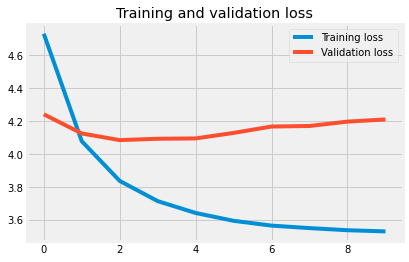

In [101]:
plot_performance(history)

It seems like added training is not really helping validation loss. Let's try to evaluate the model.

# Evaluation
I'll now predict the model performance. First, I'll get the prediction for each of the testing set. Then the prediction will be compared to the actual captions by BLEU score, which evaluates the translation quality between two texts.

In [19]:
tokenizer = processor.get_tokenizer()

In [20]:
# function to convert word ids to word
def ind2word(ind, tokenizer):
    '''Input: int, output: str'''
    return tokenizer.index_word[ind]

# function to return the prediction 
def caption_generator(img_ind, 
                      feature_dict = features, 
                      tokenizer = tokenizer, 
                      max_length = max_length):
    ''' 
    Input: image id (str), feature_dict, tokenizer, max_length(int)
    Output: a caption
    '''
    
    img_feats = get_features(feature_dict, img_ind)
    img_feats = np.expand_dims(img_feats, axis = 0)
    current_int = tokenizer.texts_to_sequences(['seqini'])
    fin_int = tokenizer.texts_to_sequences(['seqfin'])[0]
    
    # iterate each sequence and predict the next word
    for i in range(max_length):
        current_seq = pad_sequences(current_int, maxlen = max_length)
        next_int = np.argmax(model.predict([img_feats, current_seq]))
        if next_int != fin_int:
            current_int = [current_int[0] + [next_int]]
        else: break
    
    # now translate it into the word
    return ' '.join([ind2word(x, tokenizer) for x in current_seq[0] if x != 0][1:])

### Testing
Before testing on a full set, let's just take a look at one.

little girl in red shirt is playing with toy


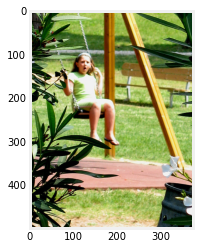

In [295]:
# testing
tmp_desc = caption_generator(test_list[0], features, tokenizer, max_length)
print(tmp_desc)

# display image
import matplotlib.image as mpimg
img = mpimg.imread(f'{flicker_img_dir}/{test_list[0]}.jpg')
plt.imshow(img)
plt.grid(False)
plt.show()

It seems like the semantic quality of description is partially correct. But syntactically it's pretty good. Let's run it on all test images and evaluate.

### BLEU (Bilingual Evaluation Understudy Score)
BLEU score is used to evaluate the model performance in translation. It compares the prediction word to word to the set of actual descriptions and returns the value between 0 and 1. 

In [21]:
from nltk.translate.bleu_score import corpus_bleu
# http://www.nltk.org/api/nltk.translate.html

`corpus_bleu()` function from NLTK package primarily takes these arguments:
- list_of_ref: list of correct descriptions 
- hypotheses: prediction to evaluate
- weights: tuple of weights of 1-gram, 2-gram, 3-gram etc.
- smoothing_function: more info here: http://acl2014.org/acl2014/W14-33/pdf/W14-3346.pdf



In [22]:
def get_bleu(img_inds):
    prediction_list = {}
    n = len(img_inds)
    hypotheses = []
    references = []
    for i, ind in enumerate(img_inds):
        caption = caption_generator(ind)
        prediction_list[ind] = caption
        hypotheses.append(caption.split())
        
        ref = get_text(descriptions, ind)
        references.append([x.split()[1:-1] for x in ref])
        
        print(i+1, '/', n, 'complete')
    bleu_1 = corpus_bleu(references, hypotheses, weights = (1, 0, 0, 0))
    bleu_2 = corpus_bleu(references, hypotheses, weights = (.5, .5, 0, 0))
    bleu_3 = corpus_bleu(references, hypotheses, weights = (.3, .3, .3, 0))
    bleu_4 = corpus_bleu(references, hypotheses)

    print(f'1-gram BLEU: {round(bleu_1, 4)}')
    print(f'2-gram BLEU: {round(bleu_2, 4)}')
    print(f'3-gram BLEU: {round(bleu_3, 4)}')
    print(f'4-gram BLEU: {round(bleu_4, 4)}')
    return prediction_list, (bleu_1, bleu_2, bleu_3, bleu_4)

In [ ]:
pred_list, score = get_bleu(test_list)

1-gram BLEU: 0.3199  
2-gram BLEU: 0.1493  
3-gram BLEU: 0.085  
4-gram BLEU: 0.0267

Not super great, but just object captioning is not our goal. So we will continue for now.

# Art Description

## 1. Real Life Captioning Model + Artworks
As a baseline, let's see how this model that is not trained on artworks do on artwork.

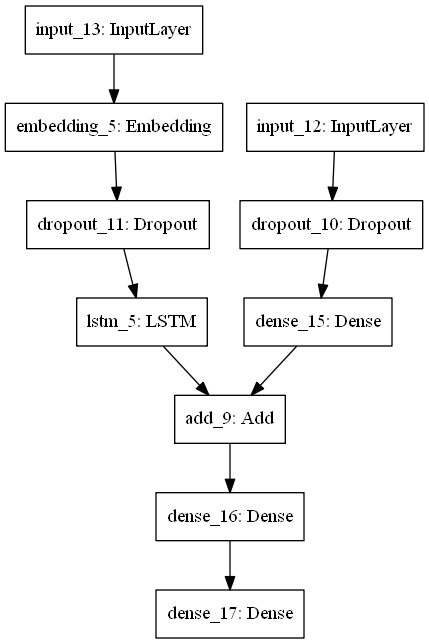

In [41]:
# reviewing structure
plot_model(model, to_file='PNG/basemodel_arch.png')

### Feature Extraction
Extracting features for art images from NASNet.

In [42]:
img_dir = 'IMAGES\paintings'

In [ ]:
art_features = feature_extractor(img_dir, NASNetLarge)

1/3067 feature extraction completed
2/3067 feature extraction completed
3/3067 feature extraction completed
4/3067 feature extraction completed
5/3067 feature extraction completed
6/3067 feature extraction completed
7/3067 feature extraction completed
8/3067 feature extraction completed
9/3067 feature extraction completed
10/3067 feature extraction completed
11/3067 feature extraction completed
12/3067 feature extraction completed
13/3067 feature extraction completed
14/3067 feature extraction completed
15/3067 feature extraction completed
16/3067 feature extraction completed
17/3067 feature extraction completed
18/3067 feature extraction completed
19/3067 feature extraction completed
20/3067 feature extraction completed
21/3067 feature extraction completed
22/3067 feature extraction completed
23/3067 feature extraction completed
24/3067 feature extraction completed
25/3067 feature extraction completed
26/3067 feature extraction completed
27/3067 feature extraction completed
28/3067 fe